# Style transfer Methods, A review

### A Neural Algorithm of Artistic Style
Source: https://harishnarayanan.org/writing/artistic-style-transfer/

Using VGG16 (or 19) and a gramm matrix to solve an optimization problem

In [14]:
# Imports
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

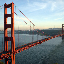

In [15]:
image_size = 64
images_path = "E:/UdeC/S1 2018/ML/Style Transfer"
# Load a content image
content_image = Image.open(images_path+"/content_images/05.jpg").resize((image_size, image_size))
style_image = Image.open(images_path+"/style_images/09.jpg").resize((image_size, image_size))
content_image # Resize just to see it at a smaller size

In [16]:
# Transforming into numeric information
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

red_mean = 103.939
green_mean = 116.779
blue_mean = 123.68

content_array[:,:,:,0] -= red_mean
content_array[:,:,:,1] -= green_mean
content_array[:,:,:,2] -= blue_mean
content_array = content_array[:,:,:,::-1]
style_array[:,:,:,0] -= red_mean
style_array[:,:,:,1] -= green_mean
style_array[:,:,:,2] -= blue_mean
style_array = style_array[:,:,:,::-1]

print(content_array.shape, style_array.shape)

(1, 64, 64, 3) (1, 64, 64, 3)


In [17]:
#Defining our loss functions
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(content-combination))

def gram_matrix(x): # Hay que entenderla bien
    features = tf.keras.backend.batch_flatten(tf.keras.backend.permute_dimensions(x, (2, 0, 1)))
    gram = tf.matmul(features, tf.transpose(features))
    return gram
def style_loss(style, combination): # Tambien
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    return tf.reduce_sum(tf.square(S - C)) / (4. * (channels ** 2) * (image_size ** 4))
def total_variation_loss(x):
    a = tf.square(x[:, :image_size-1, :image_size-1, :] - x[:, 1:, :image_size-1, :])
    b = tf.square(x[:, :image_size-1, :image_size-1, :] - x[:, :image_size-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [18]:
# Start creating the main graph
content_node = tf.constant(content_array, name = "content_image", dtype=tf.float32)
style_node = tf.constant(style_array, name = "style_image", dtype=tf.float32)
combination_image = tf.Variable(tf.random_uniform(shape=[1,image_size, image_size,3], minval = -1, maxval= 1), dtype=tf.float32)
input_ten = tf.concat([content_node, style_node, combination_image], axis = 0)

In [19]:
# Importing the VGG16 pre-trained net to use it on the content loss
vgg = tf.keras.applications.VGG16(include_top = False, weights = "imagenet", input_tensor = input_ten)

In [20]:
layers = dict([(layer.name, layer.output) for layer in vgg.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 64, 64, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 64, 64, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 32, 32, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 32, 32, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 32, 32, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 16, 16, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 16, 16, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 16, 16, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 16, 16, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 8, 8, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 8, 8, 512) dtype=float32>,
 'b

In [21]:
# Continue with the graph
content_weight = 0.025*20
style_weight = 5
total_variation_weight = 1

content_reference_layer = "block2_conv2"
style_reference_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

loss = tf.Variable(0, name = "total_loss", dtype=tf.float32)

content_feature_layer = layers[content_reference_layer]
loss = loss + content_weight * content_loss(content_feature_layer[0,:,:,:], content_feature_layer[2,:,:,:])

for layer in style_reference_layers:
    style_feature_layers = layers[layer]
    loss = loss + (style_loss(style_feature_layers[1,:,:,:], style_feature_layers[2,:,:,:]))*style_weight/len(style_reference_layers)

loss = loss + total_variation_weight * total_variation_loss(combination_image)

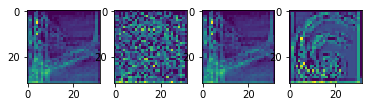

2126642.5


In [29]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.subplot(1,4,1)
    plt.imshow(layers[content_reference_layer][0,:,:,40].eval())
    plt.subplot(1,4,2)
    plt.imshow(layers[content_reference_layer][2,:,:,40].eval())
    plt.subplot(1,4,3)
    plt.imshow(layers[content_reference_layer][0,:,:,40].eval()-layers[content_reference_layer][2,:,:,40].eval())
    plt.subplot(1,4,4)
    plt.imshow(layers[content_reference_layer][1,:,:,40].eval())
    plt.show()
    print(content_loss(layers[content_reference_layer][0,:,:,:].eval(), layers[content_reference_layer][2,:,:,:].eval()).eval())

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    style_feature_layers = layers["block1_conv2"]
    print(style_loss(style_feature_layers[1,:,:,:], style_feature_layers[2,:,:,:]).eval())

46888028.0


24693210.0


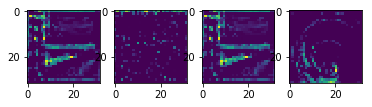

Error a la iteracion  0 :  46521056.0
Error a la iteracion  1 :  28125514.0
Error a la iteracion  2 :  25369782.0
Error a la iteracion  3 :  24759960.0
Error a la iteracion  4 :  24611030.0
Error a la iteracion  5 :  24571082.0
Error a la iteracion  6 :  24552216.0
Error a la iteracion  7 :  24538608.0
Error a la iteracion  8 :  24527414.0
Error a la iteracion  9 :  24517618.0


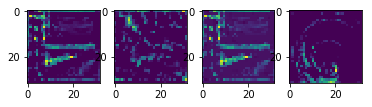

Error a la iteracion  10 :  24508730.0
Error a la iteracion  11 :  24500392.0
Error a la iteracion  12 :  24492438.0
Error a la iteracion  13 :  24484744.0
Error a la iteracion  14 :  24477246.0
Error a la iteracion  15 :  24469872.0
Error a la iteracion  16 :  24462572.0
Error a la iteracion  17 :  24455326.0
Error a la iteracion  18 :  24448096.0
Error a la iteracion  19 :  24440862.0


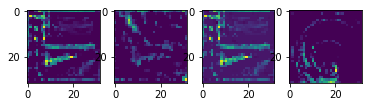

Error a la iteracion  20 :  24433638.0
Error a la iteracion  21 :  24426400.0
Error a la iteracion  22 :  24419144.0
Error a la iteracion  23 :  24411888.0
Error a la iteracion  24 :  24404580.0
Error a la iteracion  25 :  24397252.0
Error a la iteracion  26 :  24389906.0
Error a la iteracion  27 :  24382512.0
Error a la iteracion  28 :  24375072.0
Error a la iteracion  29 :  24367598.0


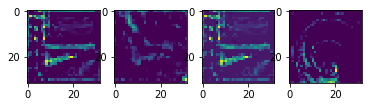

Error a la iteracion  30 :  24360086.0
Error a la iteracion  31 :  24352522.0
Error a la iteracion  32 :  24344918.0
Error a la iteracion  33 :  24337266.0
Error a la iteracion  34 :  24329572.0
Error a la iteracion  35 :  24321822.0
Error a la iteracion  36 :  24314014.0
Error a la iteracion  37 :  24306148.0
Error a la iteracion  38 :  24298222.0
Error a la iteracion  39 :  24290222.0


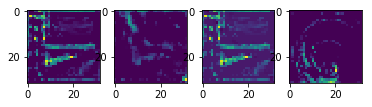

Error a la iteracion  40 :  24282182.0
Error a la iteracion  41 :  24274080.0
Error a la iteracion  42 :  24265916.0
Error a la iteracion  43 :  24257678.0
Error a la iteracion  44 :  24249374.0
Error a la iteracion  45 :  24241000.0
Error a la iteracion  46 :  24232576.0
Error a la iteracion  47 :  24224074.0
Error a la iteracion  48 :  24215518.0
Error a la iteracion  49 :  24206874.0


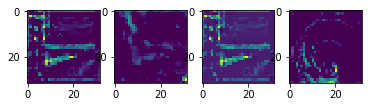

Error a la iteracion  50 :  24198170.0
Error a la iteracion  51 :  24189380.0
Error a la iteracion  52 :  24180518.0
Error a la iteracion  53 :  24171578.0
Error a la iteracion  54 :  24162550.0
Error a la iteracion  55 :  24153452.0
Error a la iteracion  56 :  24144272.0
Error a la iteracion  57 :  24135012.0
Error a la iteracion  58 :  24125684.0
Error a la iteracion  59 :  24116280.0


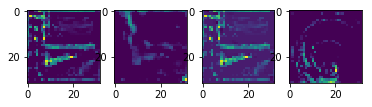

Error a la iteracion  60 :  24106786.0
Error a la iteracion  61 :  24097202.0
Error a la iteracion  62 :  24087528.0
Error a la iteracion  63 :  24077760.0
Error a la iteracion  64 :  24067902.0
Error a la iteracion  65 :  24057958.0
Error a la iteracion  66 :  24047912.0
Error a la iteracion  67 :  24037776.0
Error a la iteracion  68 :  24027556.0
Error a la iteracion  69 :  24017252.0


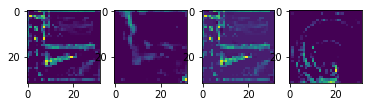

Error a la iteracion  70 :  24006850.0
Error a la iteracion  71 :  23996354.0
Error a la iteracion  72 :  23985764.0
Error a la iteracion  73 :  23975066.0
Error a la iteracion  74 :  23964276.0
Error a la iteracion  75 :  23953390.0
Error a la iteracion  76 :  23942400.0
Error a la iteracion  77 :  23931302.0
Error a la iteracion  78 :  23920100.0
Error a la iteracion  79 :  23908800.0


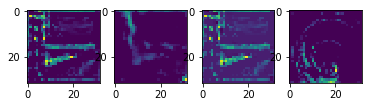

Error a la iteracion  80 :  23897392.0
Error a la iteracion  81 :  23885884.0
Error a la iteracion  82 :  23874268.0
Error a la iteracion  83 :  23862542.0
Error a la iteracion  84 :  23850706.0
Error a la iteracion  85 :  23838768.0
Error a la iteracion  86 :  23826708.0
Error a la iteracion  87 :  23814534.0
Error a la iteracion  88 :  23802248.0
Error a la iteracion  89 :  23789852.0


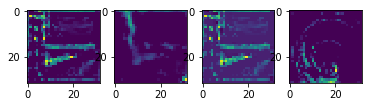

Error a la iteracion  90 :  23777348.0
Error a la iteracion  91 :  23764728.0
Error a la iteracion  92 :  23751994.0
Error a la iteracion  93 :  23739140.0
Error a la iteracion  94 :  23726164.0
Error a la iteracion  95 :  23713070.0
Error a la iteracion  96 :  23699852.0
Error a la iteracion  97 :  23686526.0
Error a la iteracion  98 :  23673076.0
Error a la iteracion  99 :  23659504.0


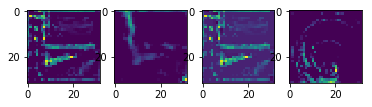

Error a la iteracion  100 :  23645812.0
Error a la iteracion  101 :  23632000.0
Error a la iteracion  102 :  23618044.0
Error a la iteracion  103 :  23603976.0
Error a la iteracion  104 :  23589768.0
Error a la iteracion  105 :  23575424.0
Error a la iteracion  106 :  23560942.0
Error a la iteracion  107 :  23546332.0
Error a la iteracion  108 :  23531574.0
Error a la iteracion  109 :  23516686.0


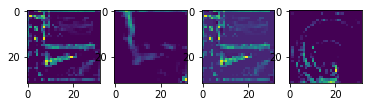

Error a la iteracion  110 :  23501656.0
Error a la iteracion  111 :  23486490.0
Error a la iteracion  112 :  23471186.0
Error a la iteracion  113 :  23455732.0
Error a la iteracion  114 :  23440136.0
Error a la iteracion  115 :  23424384.0
Error a la iteracion  116 :  23408504.0
Error a la iteracion  117 :  23392464.0
Error a la iteracion  118 :  23376274.0
Error a la iteracion  119 :  23359934.0


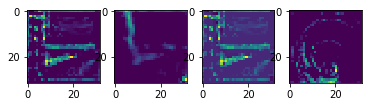

Error a la iteracion  120 :  23343454.0
Error a la iteracion  121 :  23326794.0
Error a la iteracion  122 :  23310004.0
Error a la iteracion  123 :  23293050.0
Error a la iteracion  124 :  23275942.0
Error a la iteracion  125 :  23258686.0
Error a la iteracion  126 :  23241256.0
Error a la iteracion  127 :  23223668.0
Error a la iteracion  128 :  23205914.0
Error a la iteracion  129 :  23187994.0


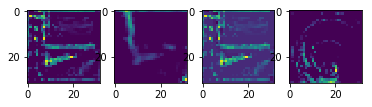

Error a la iteracion  130 :  23169914.0
Error a la iteracion  131 :  23151668.0
Error a la iteracion  132 :  23133260.0
Error a la iteracion  133 :  23114692.0
Error a la iteracion  134 :  23095972.0
Error a la iteracion  135 :  23077070.0
Error a la iteracion  136 :  23057996.0
Error a la iteracion  137 :  23038746.0
Error a la iteracion  138 :  23019334.0
Error a la iteracion  139 :  22999746.0


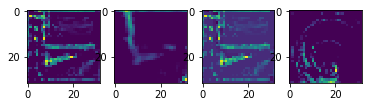

Error a la iteracion  140 :  22979990.0
Error a la iteracion  141 :  22960052.0
Error a la iteracion  142 :  22939952.0
Error a la iteracion  143 :  22919666.0
Error a la iteracion  144 :  22899208.0
Error a la iteracion  145 :  22878564.0
Error a la iteracion  146 :  22857738.0
Error a la iteracion  147 :  22836740.0
Error a la iteracion  148 :  22815554.0
Error a la iteracion  149 :  22794194.0


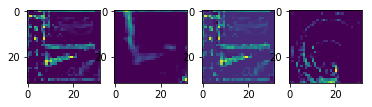

Error a la iteracion  150 :  22772656.0
Error a la iteracion  151 :  22750926.0
Error a la iteracion  152 :  22729026.0
Error a la iteracion  153 :  22706928.0
Error a la iteracion  154 :  22684644.0
Error a la iteracion  155 :  22662176.0
Error a la iteracion  156 :  22639524.0
Error a la iteracion  157 :  22616678.0
Error a la iteracion  158 :  22593638.0
Error a la iteracion  159 :  22570412.0


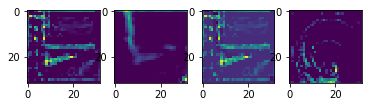

Error a la iteracion  160 :  22546996.0
Error a la iteracion  161 :  22523400.0
Error a la iteracion  162 :  22499604.0
Error a la iteracion  163 :  22475622.0
Error a la iteracion  164 :  22451440.0
Error a la iteracion  165 :  22427068.0
Error a la iteracion  166 :  22402508.0
Error a la iteracion  167 :  22377744.0
Error a la iteracion  168 :  22352792.0
Error a la iteracion  169 :  22327646.0


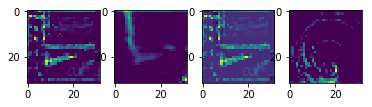

Error a la iteracion  170 :  22302306.0
Error a la iteracion  171 :  22276766.0
Error a la iteracion  172 :  22251030.0
Error a la iteracion  173 :  22225098.0
Error a la iteracion  174 :  22198966.0
Error a la iteracion  175 :  22172642.0
Error a la iteracion  176 :  22146116.0
Error a la iteracion  177 :  22119394.0
Error a la iteracion  178 :  22092456.0
Error a la iteracion  179 :  22065340.0


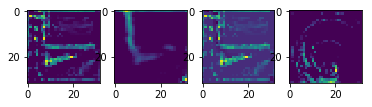

Error a la iteracion  180 :  22038026.0
Error a la iteracion  181 :  22010510.0
Error a la iteracion  182 :  21982806.0
Error a la iteracion  183 :  21954898.0
Error a la iteracion  184 :  21926794.0
Error a la iteracion  185 :  21898500.0
Error a la iteracion  186 :  21870018.0
Error a la iteracion  187 :  21841326.0
Error a la iteracion  188 :  21812452.0
Error a la iteracion  189 :  21783380.0


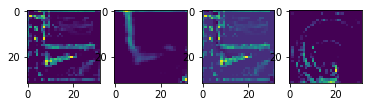

Error a la iteracion  190 :  21754116.0
Error a la iteracion  191 :  21724658.0
Error a la iteracion  192 :  21695000.0
Error a la iteracion  193 :  21665162.0
Error a la iteracion  194 :  21635128.0
Error a la iteracion  195 :  21604900.0
Error a la iteracion  196 :  21574490.0
Error a la iteracion  197 :  21543878.0
Error a la iteracion  198 :  21513076.0
Error a la iteracion  199 :  21482078.0
[[[[-1.0151161e+01  1.9998182e+01  6.3090897e+00]
   [-1.0495291e+01  2.0125486e+01  5.8639083e+00]
   [-1.1503215e+01  2.0078524e+01  5.4343934e+00]
   ...
   [-8.2609367e+00  4.3736382e+01  8.7721338e+00]
   [-8.7364569e+00  4.0621193e+01  7.9239616e+00]
   [-9.3066587e+00  3.8753986e+01  7.9941387e+00]]

  [[-1.0376584e+01  2.1228697e+01  7.1962285e+00]
   [-1.0964148e+01  2.1548708e+01  6.7210298e+00]
   [-1.2285782e+01  2.1664818e+01  6.1347895e+00]
   ...
   [-8.0349331e+00  4.5884361e+01  8.2107782e+00]
   [-8.6245174e+00  4.3379288e+01  7.1924233e+00]
   [-9.1862078e+00  4.2492714e+01 

In [32]:

# Training
learning_rate = 10

optimizer = tf.train.AdagradOptimizer(learning_rate)
gradients = optimizer.compute_gradients(loss, var_list=[combination_image])
train_step = optimizer.apply_gradients(gradients)
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, var_list=[combination_image])
n_iterations = 200
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start_image = combination_image.eval()
    print(loss.eval())
    for i in range(n_iterations):
        if i%10 == 0:
            plt.figure(i)
            plt.subplot(1,4,1)
            plt.imshow(layers[content_reference_layer][0,:,:,40].eval())
            plt.subplot(1,4,2)
            plt.imshow(layers[content_reference_layer][2,:,:,40].eval())
            plt.subplot(1,4,3)
            plt.imshow(layers[content_reference_layer][0,:,:,40].eval()-layers[content_reference_layer][2,:,:,40].eval())
            plt.subplot(1,4,4)
            plt.imshow(layers[content_reference_layer][1,:,:,50].eval())
            plt.show()
        sess.run(train_step)
        print("Error a la iteracion ", i, ": ", loss.eval())

    final_image = combination_image.eval()
    print(final_image)

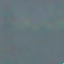

In [31]:
final_image = final_image.reshape((image_size, image_size, 3))
final_image = final_image[:,:,::-1]
final_image[:,:,0] += red_mean
final_image[:,:,1] += green_mean
final_image[:,:,2] += blue_mean
final_image = np.clip(final_image, 0, 255).astype("uint8")
Image.fromarray(final_image)

In [26]:
print(final_image)

[[[103 116 122]
  [103 115 122]
  [103 115 122]
  ...
  [103 115 123]
  [102 115 123]
  [103 115 123]]

 [[103 116 123]
  [103 115 123]
  [103 115 122]
  ...
  [102 114 123]
  [102 114 123]
  [102 113 123]]

 [[103 116 122]
  [103 115 122]
  [103 114 122]
  ...
  [102 114 122]
  [101 114 123]
  [101 116 122]]

 ...

 [[103 115 122]
  [103 114 121]
  [104 114 121]
  ...
  [101 113 120]
  [101 113 121]
  [103 113 121]]

 [[103 114 122]
  [102 114 121]
  [104 114 120]
  ...
  [102 114 120]
  [102 114 120]
  [103 114 122]]

 [[102 114 122]
  [102 113 122]
  [103 115 120]
  ...
  [101 113 122]
  [101 113 120]
  [100 116 120]]]
